# Quiz Data (Assignment)

### Loading Data

In [3]:
import json
import pandas as pd

# Load JSON files
with open("quiz_endpoint.json", "r") as f:
    quiz_endpoint = json.load(f)

with open("quiz_submission_data.json", "r") as f:
    quiz_submission = json.load(f)

with open("api_endpoint.json", "r") as f:
    historical_data = json.load(f)

# Convert to Pandas DataFrames for easier analysis
quiz_endpoint_df = pd.DataFrame(quiz_endpoint['quiz']['questions'])
quiz_submission_df = pd.DataFrame([quiz_submission])
historical_df = pd.json_normalize(historical_data)


print(historical_df.head())


       id  quiz_id                       user_id  \
0  336497       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
1  336448        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
2  333330       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
3  333242        6  YcDFSO4ZukTJnnFMgRNVwZTE4j42   
4  329504       51  YcDFSO4ZukTJnnFMgRNVwZTE4j42   

                    submitted_at                     created_at  \
0  2025-01-17T15:30:18.027+05:30  2025-01-17T15:30:18.044+05:30   
1  2025-01-17T15:17:44.042+05:30  2025-01-17T15:17:44.056+05:30   
2  2025-01-16T20:13:19.682+05:30  2025-01-16T20:13:19.699+05:30   
3  2025-01-16T20:00:11.562+05:30  2025-01-16T20:00:11.573+05:30   
4  2025-01-15T20:34:39.462+05:30  2025-01-15T20:34:39.478+05:30   

                      updated_at  score  trophy_level accuracy speed  ...  \
0  2025-01-17T15:30:18.044+05:30    108             2     90 %   100  ...   
1  2025-01-17T15:17:44.056+05:30     92             1    100 %   100  ...   
2  2025-01-16T20:13:19.699+05:30    116             2

## Analyse Data for Patterns

#### *Identify performance patterns by topics, difficulty levels, and response accuracy.*

In [4]:
historical_df['accuracy'] = historical_df['accuracy'].str.replace('%', '').astype(float)

# Analyze performance by topic
def analyze_performance_by_topic(df):
    topic_analysis = df.groupby('quiz.topic').agg({
        'score': ['mean', 'max'],
        'accuracy': 'mean',
        'user_id': 'count'
    }).reset_index()
    topic_analysis.columns = ['Topic', 'Avg_Score', 'Max_Score', 'Avg_Accuracy', 'Attempts']
    return topic_analysis

# Example usage
topic_analysis = analyze_performance_by_topic(historical_df)
print(topic_analysis)


                                      Topic   Avg_Score  Max_Score  \
0               Body Fluids and Circulation   86.666667        116   
1              Body Fluids and Circulation    54.666667         92   
2                        Human Reproduction   40.000000         40   
3                       Reproductive Health   52.000000         52   
4              Respiration and Gas Exchange   24.000000         24   
5                 human health and disease   112.000000        112   
6                 microbes in human welfare   76.000000         76   
7  principles of inheritance and variation    12.000000         12   
8                      reproductive health    52.000000         64   

   Avg_Accuracy  Attempts  
0     72.333333         3  
1     80.000000         3  
2     38.000000         1  
3     43.000000         1  
4     66.000000         1  
5     93.000000         1  
6    100.000000         1  
7     30.000000         1  
8     92.000000         2  


## Highlight Weak Areas

#### *Extract questions and topics where the user underperforms.*

In [5]:
def identify_weak_areas(quiz_submission, quiz_endpoint):
    weak_questions = []
    # Access the questions list from quiz_endpoint
    questions = quiz_endpoint['quiz']['questions']
    
    for q_id, option_id in quiz_submission['response_map'].items():
        # Find the matching question
        question = next((q for q in questions if q['id'] == int(q_id)), None)
        if question:
            # Get the correct option ID
            correct_option_id = next((o['id'] for o in question['options'] if o['is_correct']), None)
            # Check if the submitted answer is incorrect
            if correct_option_id and option_id != correct_option_id:
                weak_questions.append({
                    'question_id': q_id,
                    'topic': question['topic'],
                    'description': question['description']
                })
    return weak_questions

# Identify weak areas
weak_areas = identify_weak_areas(quiz_submission, quiz_endpoint)
print(weak_areas)


[{'question_id': '1862', 'topic': 'structural organisation in animals ', 'description': 'The secretions of endocrine glands are released directly'}, {'question_id': '1878', 'topic': 'structural organisation in animals ', 'description': 'Vasa efferentia in male frog, enter the kidney and open into'}]


#### **We found there were 2 questions wrong**
**Question_id : 1862,1878**

## Generate Recommendations

#### *Generating personalized recommendations for the user based on the identified weaknesses.*

In [6]:
def generate_recommendations(weak_areas):
    recommendations = []
    for area in weak_areas:
        recommendations.append(f"Focus on the topic '{area['topic']}' and review concepts related to: {area['description']}")
    return recommendations

# Generate recommendations
recommendations = generate_recommendations(weak_areas)
print("\n".join(recommendations))


Focus on the topic 'structural organisation in animals ' and review concepts related to: The secretions of endocrine glands are released directly
Focus on the topic 'structural organisation in animals ' and review concepts related to: Vasa efferentia in male frog, enter the kidney and open into


#### **Based on the incorrect answers we deduced the the weak areas**

## Student Persona

#### *Creating a student profile based on performance data.*



In [8]:
def define_persona(historical_data):
    # Ensure 'accuracy' is numeric
    if 'accuracy' in historical_data.columns:
        if historical_data['accuracy'].dtype == 'object':
            historical_data['accuracy'] = historical_data['accuracy'].str.replace('%', '').astype(float)
        else:
            historical_data['accuracy'] = historical_data['accuracy'].astype(float)

    # Aggregate performance by topic
    if 'quiz.topic' in historical_data.columns:
        topic_performance = historical_data.groupby('quiz.topic').agg({
            'score': 'mean',
            'accuracy': 'mean',
            'user_id': 'count'
        }).reset_index()
        topic_performance.columns = ['Topic', 'Avg_Score', 'Avg_Accuracy', 'Attempts']

        # Strengths: High accuracy (>90%)
        strengths = topic_performance[topic_performance['Avg_Accuracy'] > 90]['Topic'].tolist()

        # Weaknesses: Low accuracy (<70%)
        weaknesses = topic_performance[topic_performance['Avg_Accuracy'] < 70]['Topic'].tolist()
    else:
        strengths = []
        weaknesses = []

    # Preferred Quiz Types (if available)
    quiz_type_col = 'quiz.type' if 'quiz.type' in historical_data else None
    if quiz_type_col:
        preferred_quiz_type = historical_data[quiz_type_col].mode()[0] if not historical_data.empty else None
    else:
        preferred_quiz_type = None

    # Define the persona
    persona = {
        'strengths': strengths,
        'weaknesses': weaknesses,
        'preferred_quiz_type': preferred_quiz_type
    }
    return persona

# Call the function
student_persona = define_persona(historical_df)
print(student_persona)


{'strengths': ['human health and disease ', 'microbes in human welfare', 'reproductive health '], 'weaknesses': ['Human Reproduction', 'Reproductive Health', 'Respiration and Gas Exchange', 'principles of inheritance and variation '], 'preferred_quiz_type': None}


### Strengths

**Human Health and Disease,**
**Microbes in Human Welfare,**
**Reproductive Health**

### Weaknesses

**Human Reproduction,**
**Respiration and Gas Exchange,**
**Principles of Inheritance and Variation**


## Visualizations

### Overall Performance Trend

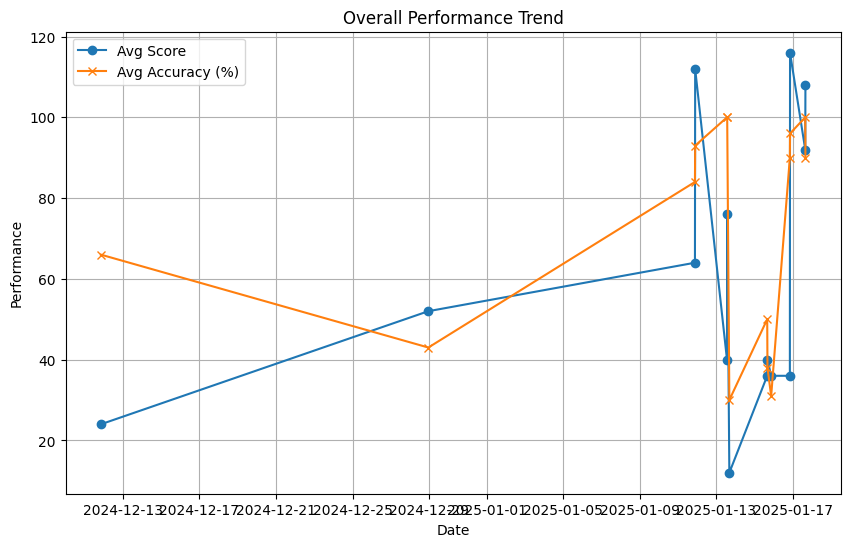

In [12]:
import matplotlib.pyplot as plt

def plot_overall_performance(historical_df):
    # Ensure submitted_at is a datetime
    historical_df['submitted_at'] = pd.to_datetime(historical_df['submitted_at'])
    
    # Group by submission date and calculate mean score and accuracy
    performance = historical_df.groupby('submitted_at').agg({
        'score': 'mean',
        'accuracy': lambda x: x.str.replace('%', '').astype(float).mean() if x.dtype == 'object' else x.mean()
    }).reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(performance['submitted_at'], performance['score'], marker='o', label='Avg Score')
    plt.plot(performance['submitted_at'], performance['accuracy'], marker='x', label='Avg Accuracy (%)')
    plt.xlabel('Date')
    plt.ylabel('Performance')
    plt.title('Overall Performance Trend')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_overall_performance(historical_df)


### Topic Wise Performance

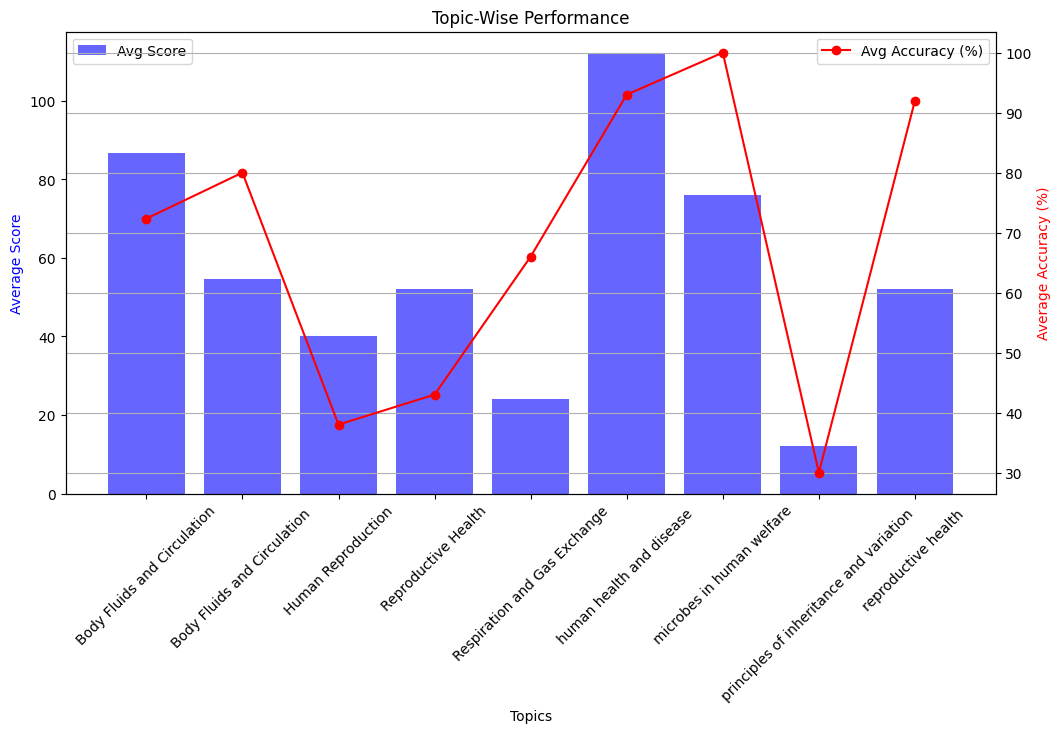

In [13]:
def plot_topic_performance(historical_df):
    # Aggregate performance by topic
    topic_performance = historical_df.groupby('quiz.topic').agg({
        'score': 'mean',
        'accuracy': lambda x: x.str.replace('%', '').astype(float).mean() if x.dtype == 'object' else x.mean()
    }).reset_index()

    # Plot the data
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    ax1.bar(topic_performance['quiz.topic'], topic_performance['score'], color='b', alpha=0.6, label='Avg Score')
    ax2.plot(topic_performance['quiz.topic'], topic_performance['accuracy'], color='r', marker='o', label='Avg Accuracy (%)')

    ax1.set_xlabel('Topics')
    ax1.set_ylabel('Average Score', color='b')
    ax2.set_ylabel('Average Accuracy (%)', color='r')
    plt.title('Topic-Wise Performance')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_topic_performance(historical_df)


### Distribution of Scores

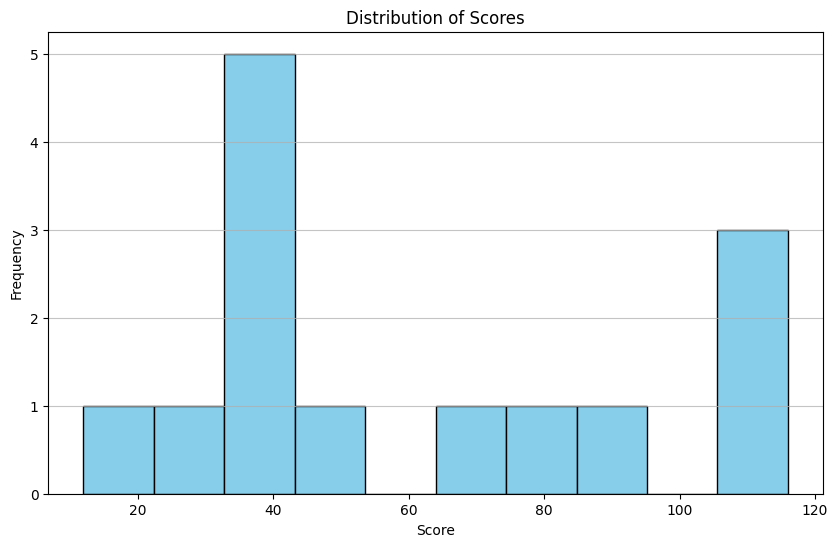

In [14]:
def plot_score_distribution(historical_df):
    plt.figure(figsize=(10, 6))
    plt.hist(historical_df['score'], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Scores')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_score_distribution(historical_df)


### Accuracy vs Speed

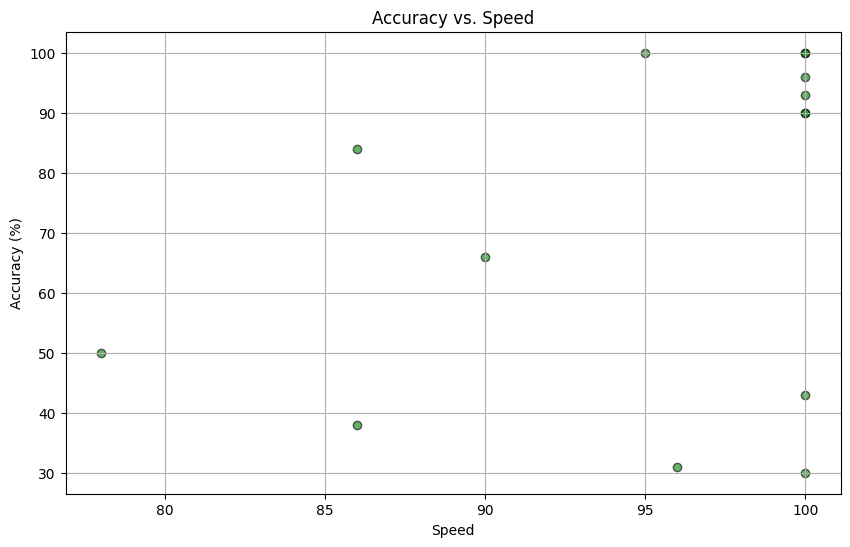

In [15]:
def plot_accuracy_vs_speed(historical_df):
    # Convert accuracy to numeric if needed
    if historical_df['accuracy'].dtype == 'object':
        historical_df['accuracy'] = historical_df['accuracy'].str.replace('%', '').astype(float)
    historical_df['speed'] = historical_df['speed'].astype(float)

    plt.figure(figsize=(10, 6))
    plt.scatter(historical_df['speed'], historical_df['accuracy'], alpha=0.6, c='green', edgecolor='black')
    plt.xlabel('Speed')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Speed')
    plt.grid(True)
    plt.show()

plot_accuracy_vs_speed(historical_df)
